# **Red neuronal convolucional para el diagnóstico de nódulos tiroideos según la clasificación EU-TIRADS**

## Por Alejandro Martínez Hernández

### Notebook 4/4

# **Creación de modelos**

Para la siguiente parte se crearan los siguientes modelos de clasificación simple:
- model1
- model2

## **MobileNetV3**

### **Small Version**

#### **Adam Optimizer**

Epoch 1/50


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 320ms/step - accuracy: 0.5250 - loss: 0.6991 - val_accuracy: 0.5217 - val_loss: 0.7870
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.6377 - loss: 0.8067 - val_accuracy: 0.4783 - val_loss: 0.7454
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.4490 - loss: 0.8017 - val_accuracy: 0.4783 - val_loss: 0.7361
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.5556 - loss: 0.7086 - val_accuracy: 0.5217 - val_loss: 0.8368
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.5421 - loss: 0.7985 - val_accuracy: 0.5217 - val_loss: 0.6911
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.5611 - loss: 0.6759 - val_accuracy: 0.4783 - val_loss: 0.6947
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.4540 - loss: 0.6886 - val_accuracy: 0.5217 - val_loss: 0.7101
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.5486 - loss: 0.7246 - val_accuracy: 0.4783 - val_loss: 0.7094
Epo

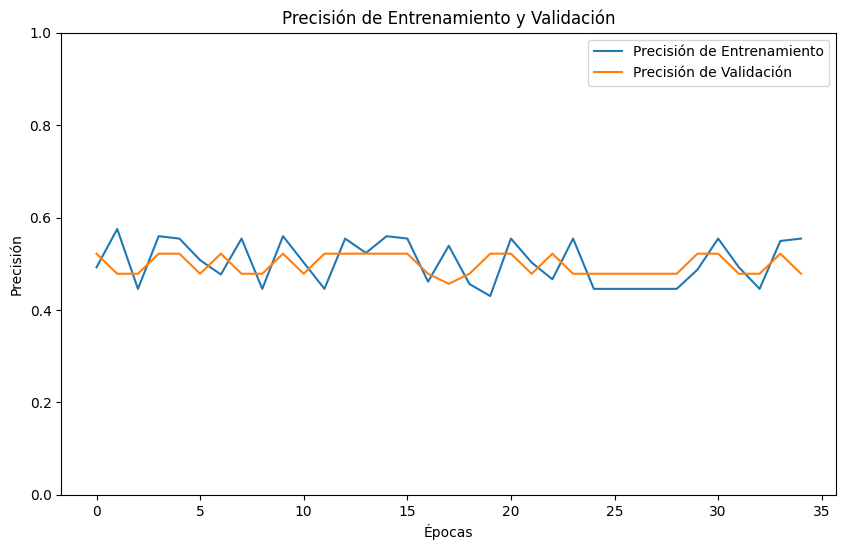

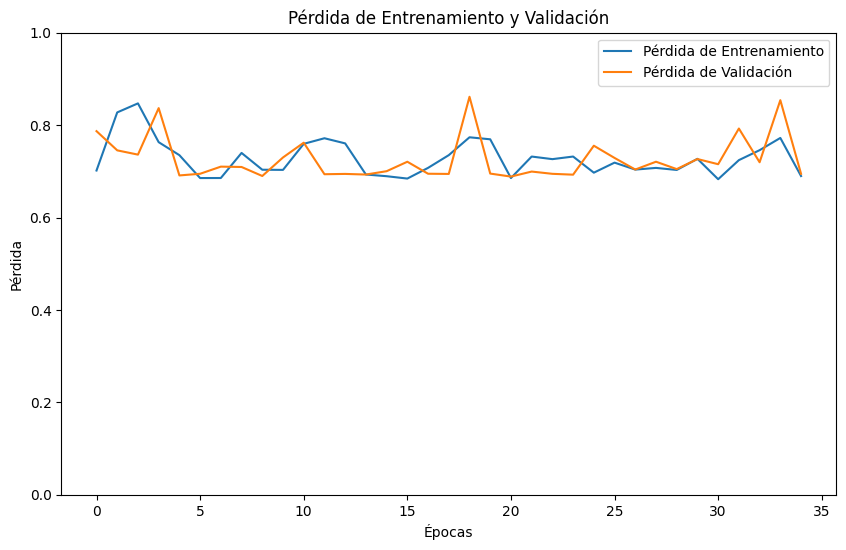

In [14]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Función para cargar las imágenes y las etiquetas desde las carpetas
def load_images(base_dir, input_size=(224, 224)):
    """
    Carga imágenes y etiquetas desde el directorio base.

    Args:
    base_dir (str): Directorio base donde están ubicadas las carpetas de imágenes.
    input_size (tuple): Tamaño al cual se redimensionarán las imágenes.

    Returns:
    data (np.array): Imágenes cargadas.
    labels (np.array): Etiquetas correspondientes.
    groups (np.array): Identificadores de los pacientes.
    """
    categories = ['high', 'low']
    data = []
    labels = []
    groups = []

    for category in categories:
        path = os.path.join(base_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = cv2.resize(image, input_size)
                image = np.stack((image,) * 3, axis=-1)
                data.append(image)
                labels.append(class_num)
                patient_id = img.split('_')[0]
                groups.append(patient_id)

    return np.array(data), np.array(labels), np.array(groups)

# Configurar generadores de imágenes
def setup_image_generators(X_train, X_val, y_train, y_val):
    """
    Configura generadores de imágenes para entrenamiento y validación.

    Args:
    X_train (np.array): Imágenes de entrenamiento.
    X_val (np.array): Imágenes de validación.
    y_train (np.array): Etiquetas de entrenamiento.
    y_val (np.array): Etiquetas de validación.

    Returns:
    train_generator, val_generator: Generadores para el entrenamiento y validación.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=5,
        zoom_range=[0.2, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow(X_train, y_train)
    val_generator = validation_datagen.flow(X_val, y_val)

    return train_generator, val_generator

# Crear el modelo
def create_model(input_shape=(224, 224, 3)):
    """
    Crea un modelo de red neuronal secuencial utilizando MobileNetV3 como base.

    Args:
    input_shape (tuple): Dimensiones de las imágenes de entrada.

    Returns:
    model: Modelo compilado de TensorFlow.
    """
    base_model = MobileNetV3Small(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ruta al directorio de imágenes
base_directory = 'db_unal/organized/images/cropped'
X, y, groups = load_images(base_directory)

# Dividir los datos en conjuntos de entrenamiento y validación
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups=groups))

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

# Configurar generadores de imágenes
train_gen, val_gen = setup_image_generators(X_train, X_val, y_train, y_val)

# Crear y compilar el modelo
model = create_model()

# Calcular los pesos de clase para manejar datos desbalanceados
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weights[i] for i in range(len(weights))}

# Configurar los callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=30,
    verbose=1,
    mode='min'
)

# Entrenar el modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy = model.evaluate(val_gen)
print(f'Validation accuracy: {val_accuracy:.4f}')

# Métricas de desempeño
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Precisión de Entrenamiento')
plt.plot(epochs, val_acc, label='Precisión de Validación')
plt.ylim(0, 1.0)
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Pérdida de Entrenamiento')
plt.plot(epochs, val_loss, label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylim(0, 1.0)
plt.ylabel('Pérdida')
plt.legend()
plt.show()

#### **SGD optimizer**

Epoch 1/50


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 337ms/step - accuracy: 0.6181 - loss: 0.6549 - val_accuracy: 0.5217 - val_loss: 0.6943
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.5212 - loss: 0.7029 - val_accuracy: 0.4783 - val_loss: 0.6958
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.4821 - loss: 0.7788 - val_accuracy: 0.5217 - val_loss: 0.7471
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.5153 - loss: 0.7240 - val_accuracy: 0.4783 - val_loss: 0.8817
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.4453 - loss: 0.9077 - val_accuracy: 0.5217 - val_loss: 0.6955
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.5649 - loss: 0.6898 - val_accuracy: 0.5217 - val_loss: 0.6949
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.3595 - loss: 0.7493 - val_accuracy: 0.5217 - val_loss: 0.6927
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.5432 - loss: 0.7238 - val_accuracy: 0.4783 - val_loss: 0.7852
Epo

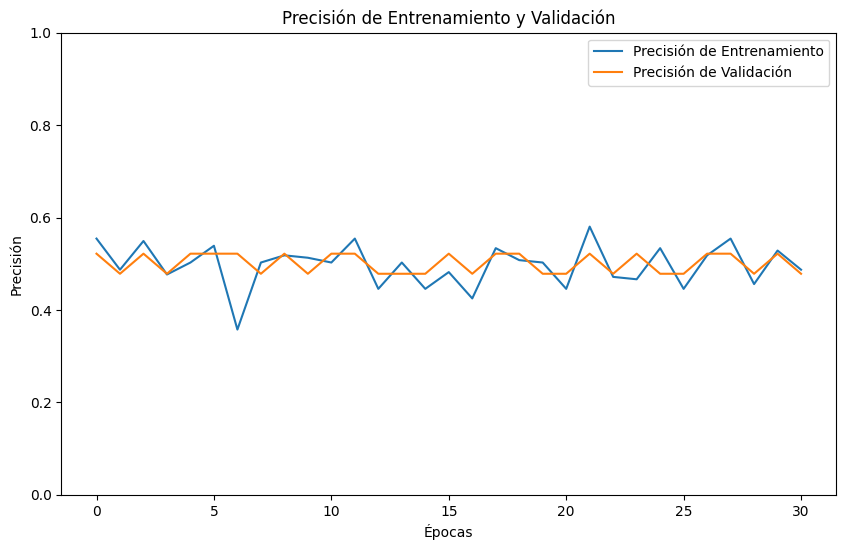

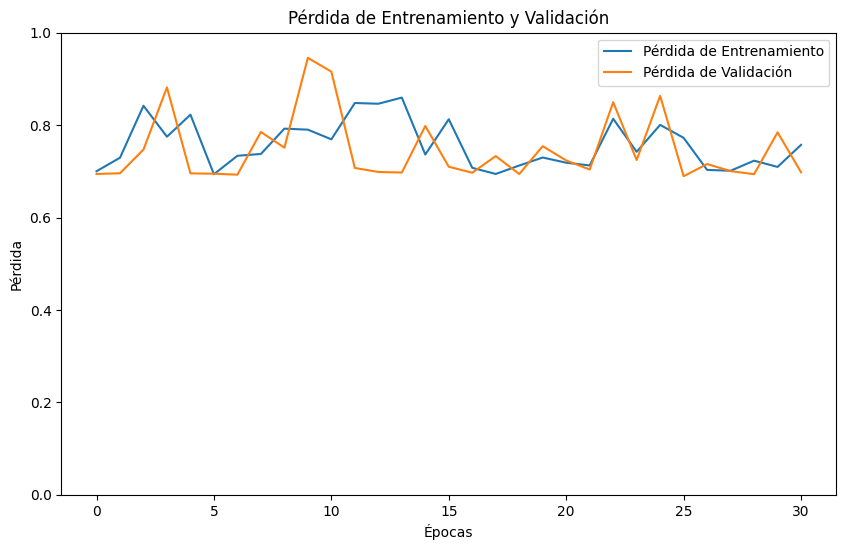

In [15]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD

# Función para cargar las imágenes y las etiquetas desde las carpetas
def load_images(base_dir, input_size=(224, 224)):
    """
    Carga imágenes y etiquetas desde el directorio base.

    Args:
    base_dir (str): Directorio base donde están ubicadas las carpetas de imágenes.
    input_size (tuple): Tamaño al cual se redimensionarán las imágenes.

    Returns:
    data (np.array): Imágenes cargadas.
    labels (np.array): Etiquetas correspondientes.
    groups (np.array): Identificadores de los pacientes.
    """
    categories = ['high', 'low']
    data = []
    labels = []
    groups = []

    for category in categories:
        path = os.path.join(base_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = cv2.resize(image, input_size)
                image = np.stack((image,) * 3, axis=-1)
                data.append(image)
                labels.append(class_num)
                patient_id = img.split('_')[0]
                groups.append(patient_id)

    return np.array(data), np.array(labels), np.array(groups)

# Configurar generadores de imágenes
def setup_image_generators(X_train, X_val, y_train, y_val):
    """
    Configura generadores de imágenes para entrenamiento y validación.

    Args:
    X_train (np.array): Imágenes de entrenamiento.
    X_val (np.array): Imágenes de validación.
    y_train (np.array): Etiquetas de entrenamiento.
    y_val (np.array): Etiquetas de validación.

    Returns:
    train_generator, val_generator: Generadores para el entrenamiento y validación.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=5,
        zoom_range=[0.2, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow(X_train, y_train)
    val_generator = validation_datagen.flow(X_val, y_val)

    return train_generator, val_generator

# Crear el modelo
def create_model(input_shape=(224, 224, 3)):
    """
    Crea un modelo de red neuronal secuencial utilizando MobileNetV3 como base.

    Args:
    input_shape (tuple): Dimensiones de las imágenes de entrada.

    Returns:
    model: Modelo compilado de TensorFlow.
    """
    base_model = MobileNetV3Small(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ruta al directorio de imágenes
base_directory = 'db_unal/organized/images/cropped'
X, y, groups = load_images(base_directory)

# Dividir los datos en conjuntos de entrenamiento y validación
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups=groups))

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

# Configurar generadores de imágenes
train_gen, val_gen = setup_image_generators(X_train, X_val, y_train, y_val)

# Crear y compilar el modelo
model = create_model()

# Calcular los pesos de clase para manejar datos desbalanceados
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weights[i] for i in range(len(weights))}

# Configurar los callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=30,
    verbose=1,
    mode='min'
)

# Entrenar el modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy = model.evaluate(val_gen)
print(f'Validation accuracy: {val_accuracy:.4f}')

# Métricas de desempeño
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Precisión de Entrenamiento')
plt.plot(epochs, val_acc, label='Precisión de Validación')
plt.ylim(0, 1.0)
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Pérdida de Entrenamiento')
plt.plot(epochs, val_loss, label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylim(0, 1.0)
plt.ylabel('Pérdida')
plt.legend()
plt.show()

### **Large Version**

#### **Adam Optimizer**

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.4769 - loss: 0.8046
Epoch 1: val_loss improved from inf to 0.70104, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 629ms/step - accuracy: 0.4789 - loss: 0.8100 - val_accuracy: 0.5217 - val_loss: 0.7010
Epoch 2/50
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.4828 - loss: 0.7000
Epoch 2: val_loss did not improve from 0.70104
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 388ms/step - accuracy: 0.4813 - loss: 0.6935 - val_accuracy: 0.4783 - val_loss: 0.8289
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.4140 - loss: 0.8096
Epoch 3: val_loss improved from 0.70104 to 0.68739, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 424ms/step - accuracy: 0.4167 - loss: 0.8074 - val_accuracy: 0.5217 - val_loss: 0.6874
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.6158 - loss: 0.6697
Epoch 4: val_loss did not improve from 0.68739
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 372ms/step - accuracy: 0.6081 - loss: 0.6

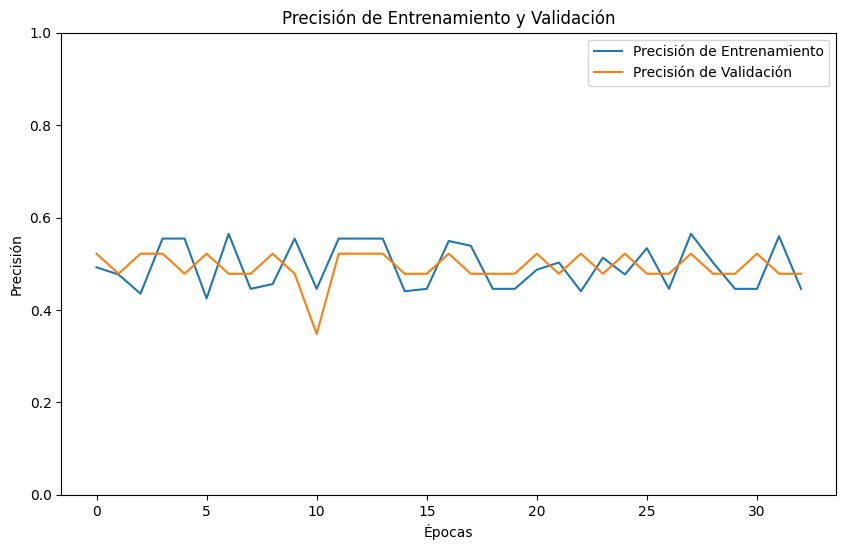

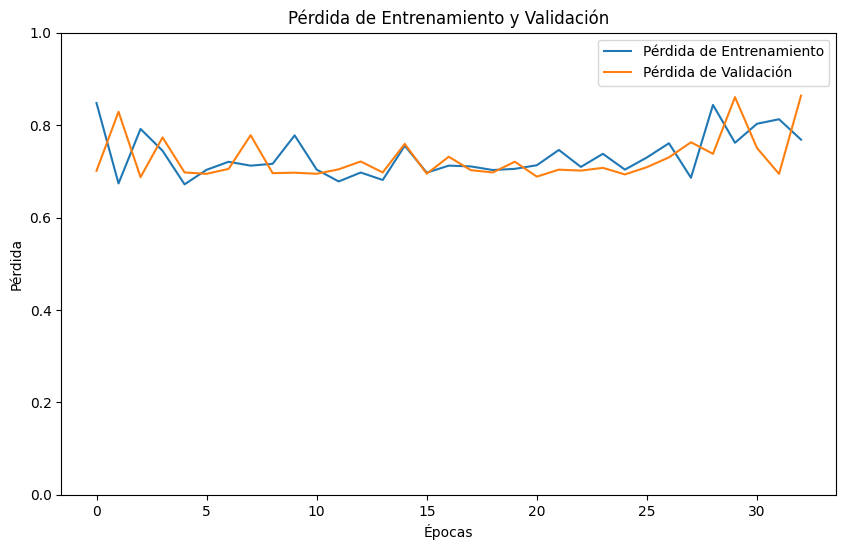

In [10]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Función para cargar las imágenes y las etiquetas desde las carpetas
def load_images(base_dir, input_size=(224, 224)):
    """
    Carga imágenes y etiquetas desde el directorio base.

    Args:
    base_dir (str): Directorio base donde están ubicadas las carpetas de imágenes.
    input_size (tuple): Tamaño al cual se redimensionarán las imágenes.

    Returns:
    data (np.array): Imágenes cargadas.
    labels (np.array): Etiquetas correspondientes.
    groups (np.array): Identificadores de los pacientes.
    """
    categories = ['high', 'low']
    data = []
    labels = []
    groups = []

    for category in categories:
        path = os.path.join(base_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = cv2.resize(image, input_size)
                image = np.stack((image,) * 3, axis=-1)
                data.append(image)
                labels.append(class_num)
                patient_id = img.split('_')[0]
                groups.append(patient_id)

    return np.array(data), np.array(labels), np.array(groups)

# Configurar generadores de imágenes
def setup_image_generators(X_train, X_val, y_train, y_val):
    """
    Configura generadores de imágenes para entrenamiento y validación.

    Args:
    X_train (np.array): Imágenes de entrenamiento.
    X_val (np.array): Imágenes de validación.
    y_train (np.array): Etiquetas de entrenamiento.
    y_val (np.array): Etiquetas de validación.

    Returns:
    train_generator, val_generator: Generadores para el entrenamiento y validación.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=5,
        zoom_range=[0.2, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow(X_train, y_train)
    val_generator = validation_datagen.flow(X_val, y_val)

    return train_generator, val_generator

# Crear el modelo
def create_model(input_shape=(224, 224, 3)):
    """
    Crea un modelo de red neuronal secuencial utilizando MobileNetV3 como base.

    Args:
    input_shape (tuple): Dimensiones de las imágenes de entrada.

    Returns:
    model: Modelo compilado de TensorFlow.
    """
    base_model = MobileNetV3Large(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ruta al directorio de imágenes
base_directory = 'db_unal/organized/images/cropped'
X, y, groups = load_images(base_directory)

# Dividir los datos en conjuntos de entrenamiento y validación
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups=groups))

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

# Configurar generadores de imágenes
train_gen, val_gen = setup_image_generators(X_train, X_val, y_train, y_val)

# Crear y compilar el modelo
model = create_model()

# Calcular los pesos de clase para manejar datos desbalanceados
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weights[i] for i in range(len(weights))}

# Configurar los callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=30,
    verbose=1,
    mode='min'
)


# Entrenar el modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy = model.evaluate(val_gen)
print(f'Validation accuracy: {val_accuracy:.4f}')

# Métricas de desempeño
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Precisión de Entrenamiento')
plt.plot(epochs, val_acc, label='Precisión de Validación')
plt.ylim(0, 1.0)
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Pérdida de Entrenamiento')
plt.plot(epochs, val_loss, label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylim(0, 1.0)
plt.ylabel('Pérdida')
plt.legend()
plt.show()

#### **SGD optimizer**

Epoch 1/50


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 741ms/step - accuracy: 0.6124 - loss: 0.6788 - val_accuracy: 0.4783 - val_loss: 1.0143
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 401ms/step - accuracy: 0.4315 - loss: 0.9192 - val_accuracy: 0.5217 - val_loss: 0.6936
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 398ms/step - accuracy: 0.5296 - loss: 0.9562 - val_accuracy: 0.5217 - val_loss: 1.0878
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 458ms/step - accuracy: 0.3674 - loss: 1.6394 - val_accuracy: 0.5217 - val_loss: 1.2146
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 401ms/step - accuracy: 0.5305 - loss: 1.0002 - val_accuracy: 0.4783 - val_loss: 1.3040
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 402ms/step - accuracy: 0.4565 - loss: 1.1966 - val_accuracy: 0.4783 - val_loss: 1.6066
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 440ms/step - accuracy: 0.4986 - loss: 1.2307 - val_accuracy: 0.5217 - val_loss: 1.3766
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 453ms/step - accuracy: 0.5229 - loss: 1.1456 - val_accuracy: 0.5217 - val_loss: 0.7832
Ep

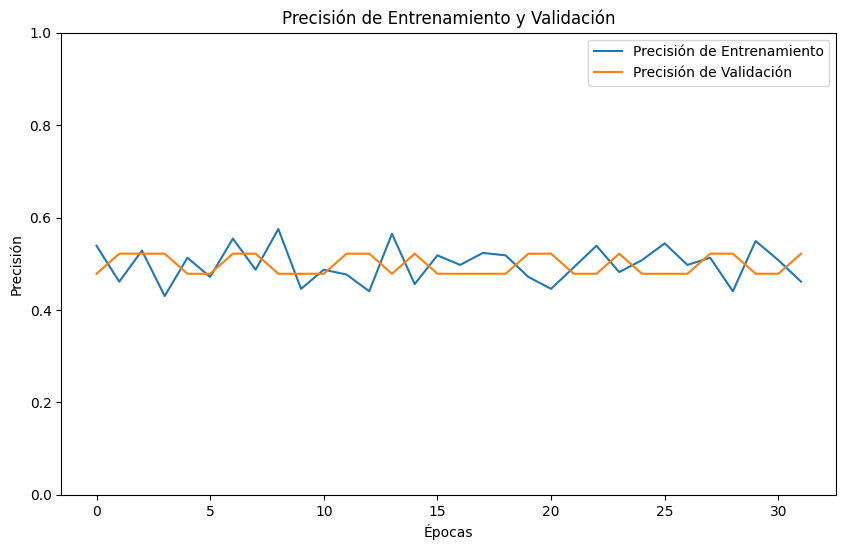

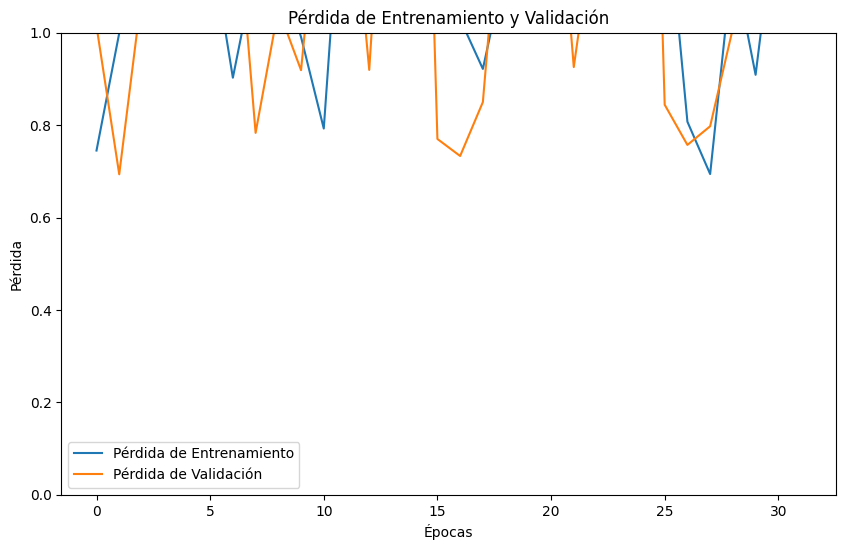

In [16]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD

# Función para cargar las imágenes y las etiquetas desde las carpetas
def load_images(base_dir, input_size=(224, 224)):
    """
    Carga imágenes y etiquetas desde el directorio base.

    Args:
    base_dir (str): Directorio base donde están ubicadas las carpetas de imágenes.
    input_size (tuple): Tamaño al cual se redimensionarán las imágenes.

    Returns:
    data (np.array): Imágenes cargadas.
    labels (np.array): Etiquetas correspondientes.
    groups (np.array): Identificadores de los pacientes.
    """
    categories = ['high', 'low']
    data = []
    labels = []
    groups = []

    for category in categories:
        path = os.path.join(base_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = cv2.resize(image, input_size)
                image = np.stack((image,) * 3, axis=-1)
                data.append(image)
                labels.append(class_num)
                patient_id = img.split('_')[0]
                groups.append(patient_id)

    return np.array(data), np.array(labels), np.array(groups)

# Configurar generadores de imágenes
def setup_image_generators(X_train, X_val, y_train, y_val):
    """
    Configura generadores de imágenes para entrenamiento y validación.

    Args:
    X_train (np.array): Imágenes de entrenamiento.
    X_val (np.array): Imágenes de validación.
    y_train (np.array): Etiquetas de entrenamiento.
    y_val (np.array): Etiquetas de validación.

    Returns:
    train_generator, val_generator: Generadores para el entrenamiento y validación.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=5,
        zoom_range=[0.2, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow(X_train, y_train)
    val_generator = validation_datagen.flow(X_val, y_val)

    return train_generator, val_generator

# Crear el modelo
def create_model(input_shape=(224, 224, 3)):
    """
    Crea un modelo de red neuronal secuencial utilizando MobileNetV3 como base.

    Args:
    input_shape (tuple): Dimensiones de las imágenes de entrada.

    Returns:
    model: Modelo compilado de TensorFlow.
    """
    base_model = MobileNetV3Large(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ruta al directorio de imágenes
base_directory = 'db_unal/organized/images/cropped'
X, y, groups = load_images(base_directory)

# Dividir los datos en conjuntos de entrenamiento y validación
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups=groups))

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

# Configurar generadores de imágenes
train_gen, val_gen = setup_image_generators(X_train, X_val, y_train, y_val)

# Crear y compilar el modelo
model = create_model()

# Calcular los pesos de clase para manejar datos desbalanceados
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weights[i] for i in range(len(weights))}

# Configurar los callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=30,
    verbose=1,
    mode='min'
)

# Entrenar el modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy = model.evaluate(val_gen)
print(f'Validation accuracy: {val_accuracy:.4f}')

# Métricas de desempeño
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Precisión de Entrenamiento')
plt.plot(epochs, val_acc, label='Precisión de Validación')
plt.ylim(0, 1.0)
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Pérdida de Entrenamiento')
plt.plot(epochs, val_loss, label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylim(0, 1.0)
plt.ylabel('Pérdida')
plt.legend()
plt.show()

## **ResNet**

### **ResNet50**

#### **Adam Optimizer**

Epoch 1/50


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5534 - loss: 0.9400
Epoch 1: val_loss improved from inf to 0.93114, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5464 - loss: 0.9403 - val_accuracy: 0.5217 - val_loss: 0.9311
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5371 - loss: 0.9673  
Epoch 2: val_loss did not improve from 0.93114
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5360 - loss: 0.9575 - val_accuracy: 0.4783 - val_loss: 1.0753
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4055 - loss: 1.2014   
Epoch 3: val_loss improved from 0.93114 to 0.89150, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4105 - loss: 1.1796 - val_accuracy: 0.5217 - val_loss: 0.8915
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5163 - loss: 1.0468  
Epoch 4: val_loss did not improve from 0.89150
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5139 - loss: 1.0324 - val_accu

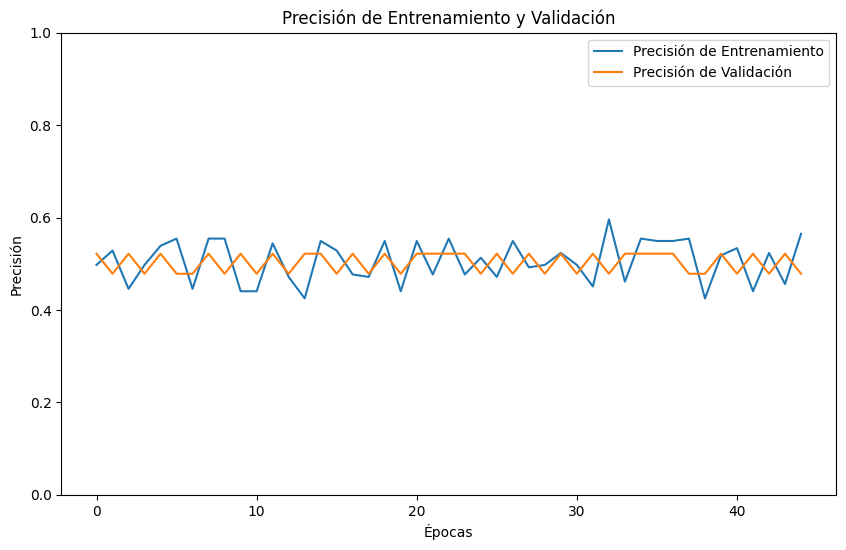

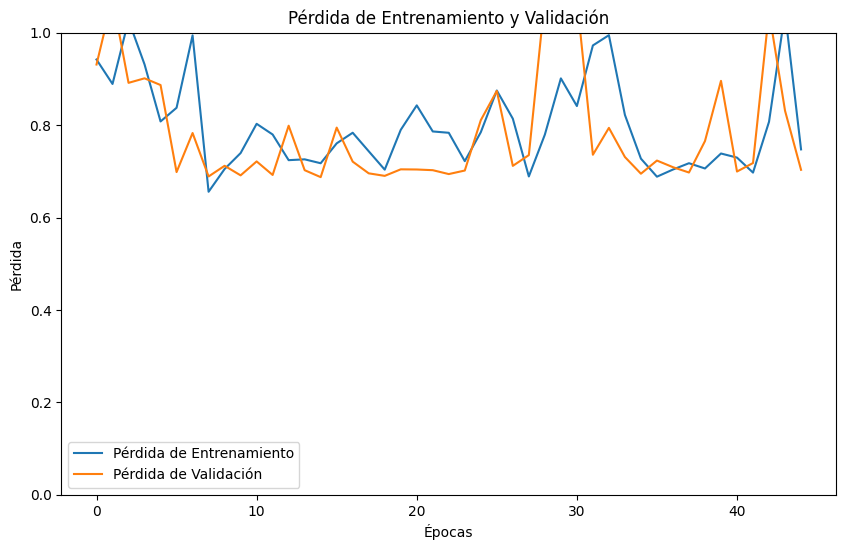

In [17]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Función para cargar las imágenes y las etiquetas desde las carpetas
def load_images(base_dir, input_size=(224, 224)):
    """
    Carga imágenes y etiquetas desde el directorio base.

    Args:
    base_dir (str): Directorio base donde están ubicadas las carpetas de imágenes.
    input_size (tuple): Tamaño al cual se redimensionarán las imágenes.

    Returns:
    data (np.array): Imágenes cargadas.
    labels (np.array): Etiquetas correspondientes.
    groups (np.array): Identificadores de los pacientes.
    """
    categories = ['high', 'low']
    data = []
    labels = []
    groups = []

    for category in categories:
        path = os.path.join(base_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = cv2.resize(image, input_size)
                image = np.stack((image,) * 3, axis=-1)
                data.append(image)
                labels.append(class_num)
                patient_id = img.split('_')[0]
                groups.append(patient_id)

    return np.array(data), np.array(labels), np.array(groups)

# Configurar generadores de imágenes
def setup_image_generators(X_train, X_val, y_train, y_val):
    """
    Configura generadores de imágenes para entrenamiento y validación.

    Args:
    X_train (np.array): Imágenes de entrenamiento.
    X_val (np.array): Imágenes de validación.
    y_train (np.array): Etiquetas de entrenamiento.
    y_val (np.array): Etiquetas de validación.

    Returns:
    train_generator, val_generator: Generadores para el entrenamiento y validación.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=5,
        zoom_range=[0.2, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow(X_train, y_train)
    val_generator = validation_datagen.flow(X_val, y_val)

    return train_generator, val_generator

# Crear el modelo
def create_model(input_shape=(224, 224, 3)):
    """
    Crea un modelo de red neuronal secuencial utilizando MobileNetV3 como base.

    Args:
    input_shape (tuple): Dimensiones de las imágenes de entrada.

    Returns:
    model: Modelo compilado de TensorFlow.
    """
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ruta al directorio de imágenes
base_directory = 'db_unal/organized/images/cropped'
X, y, groups = load_images(base_directory)

# Dividir los datos en conjuntos de entrenamiento y validación
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups=groups))

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

# Configurar generadores de imágenes
train_gen, val_gen = setup_image_generators(X_train, X_val, y_train, y_val)

# Crear y compilar el modelo
model = create_model()

# Calcular los pesos de clase para manejar datos desbalanceados
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weights[i] for i in range(len(weights))}

# Configurar los callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=30,
    verbose=1,
    mode='min'
)

# Entrenar el modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy = model.evaluate(val_gen)
print(f'Validation accuracy: {val_accuracy:.4f}')

# Métricas de desempeño
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Precisión de Entrenamiento')
plt.plot(epochs, val_acc, label='Precisión de Validación')
plt.ylim(0, 1.0)
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Pérdida de Entrenamiento')
plt.plot(epochs, val_loss, label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylim(0, 1.0)
plt.ylabel('Pérdida')
plt.legend()
plt.show()

#### **SGD Optimizer**

Epoch 1/50


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4978 - loss: 1.5884   
Epoch 1: val_loss improved from inf to 2.18247, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.4984 - loss: 1.6858 - val_accuracy: 0.5217 - val_loss: 2.1825
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5738 - loss: 3.2505   
Epoch 2: val_loss improved from 2.18247 to 2.05132, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5669 - loss: 3.2631 - val_accuracy: 0.5217 - val_loss: 2.0513
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5769 - loss: 2.5060   
Epoch 3: val_loss did not improve from 2.05132
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5734 - loss: 2.5988 - val_accuracy: 0.4783 - val_loss: 3.5381
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6154 - loss: 1.9997   
Epoch 4: val_loss improved from 2.05132 to 0.86733, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step -

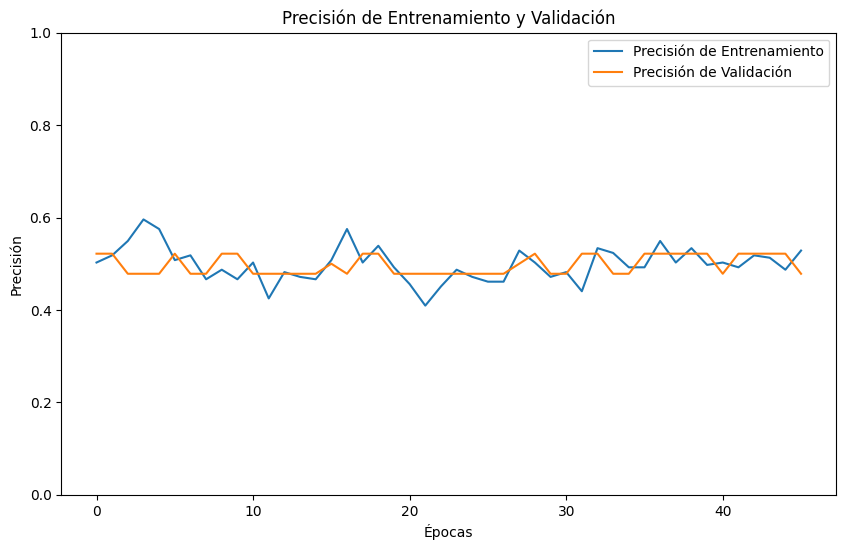

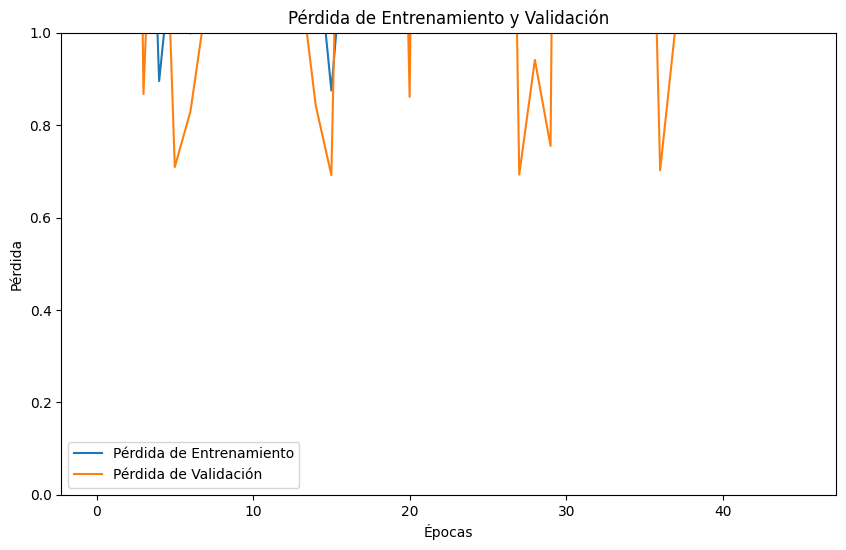

In [19]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

# Función para cargar las imágenes y las etiquetas desde las carpetas
def load_images(base_dir, input_size=(224, 224)):
    """
    Carga imágenes y etiquetas desde el directorio base.

    Args:
    base_dir (str): Directorio base donde están ubicadas las carpetas de imágenes.
    input_size (tuple): Tamaño al cual se redimensionarán las imágenes.

    Returns:
    data (np.array): Imágenes cargadas.
    labels (np.array): Etiquetas correspondientes.
    groups (np.array): Identificadores de los pacientes.
    """
    categories = ['high', 'low']
    data = []
    labels = []
    groups = []

    for category in categories:
        path = os.path.join(base_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = cv2.resize(image, input_size)
                image = np.stack((image,) * 3, axis=-1)
                data.append(image)
                labels.append(class_num)
                patient_id = img.split('_')[0]
                groups.append(patient_id)

    return np.array(data), np.array(labels), np.array(groups)

# Configurar generadores de imágenes
def setup_image_generators(X_train, X_val, y_train, y_val):
    """
    Configura generadores de imágenes para entrenamiento y validación.

    Args:
    X_train (np.array): Imágenes de entrenamiento.
    X_val (np.array): Imágenes de validación.
    y_train (np.array): Etiquetas de entrenamiento.
    y_val (np.array): Etiquetas de validación.

    Returns:
    train_generator, val_generator: Generadores para el entrenamiento y validación.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=5,
        zoom_range=[0.2, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow(X_train, y_train)
    val_generator = validation_datagen.flow(X_val, y_val)

    return train_generator, val_generator

# Crear el modelo
def create_model(input_shape=(224, 224, 3)):
    """
    Crea un modelo de red neuronal secuencial utilizando MobileNetV3 como base.

    Args:
    input_shape (tuple): Dimensiones de las imágenes de entrada.

    Returns:
    model: Modelo compilado de TensorFlow.
    """
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ruta al directorio de imágenes
base_directory = 'db_unal/organized/images/cropped'
X, y, groups = load_images(base_directory)

# Dividir los datos en conjuntos de entrenamiento y validación
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups=groups))

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

# Configurar generadores de imágenes
train_gen, val_gen = setup_image_generators(X_train, X_val, y_train, y_val)

# Crear y compilar el modelo
model = create_model()

# Calcular los pesos de clase para manejar datos desbalanceados
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weights[i] for i in range(len(weights))}

# Configurar los callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=30,
    verbose=1,
    mode='min'
)


# Entrenar el modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy = model.evaluate(val_gen)
print(f'Validation accuracy: {val_accuracy:.4f}')

# Métricas de desempeño
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Precisión de Entrenamiento')
plt.plot(epochs, val_acc, label='Precisión de Validación')
plt.ylim(0, 1.0)
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Pérdida de Entrenamiento')
plt.plot(epochs, val_loss, label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylim(0, 1.0)
plt.ylabel('Pérdida')
plt.legend()
plt.show()

### **ResNet101**

#### **Adam Optimizer**

Epoch 1/50


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3957 - loss: 0.8599
Epoch 1: val_loss improved from inf to 0.69311, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.3981 - loss: 0.8605 - val_accuracy: 0.4783 - val_loss: 0.6931
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5327 - loss: 0.7108
Epoch 2: val_loss did not improve from 0.69311
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5341 - loss: 0.7093 - val_accuracy: 0.5217 - val_loss: 0.6951
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5284 - loss: 0.7335
Epoch 3: val_loss did not improve from 0.69311
7/7 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.5303 - loss: 0.7301 - val_accuracy: 0.5217 - val_loss: 0.6986
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6100 - loss: 0.6705
Epoch 4: val_loss improved from 0.69311 to 0.69025, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.6030 - loss: 0.6764 - val_accuracy: 0

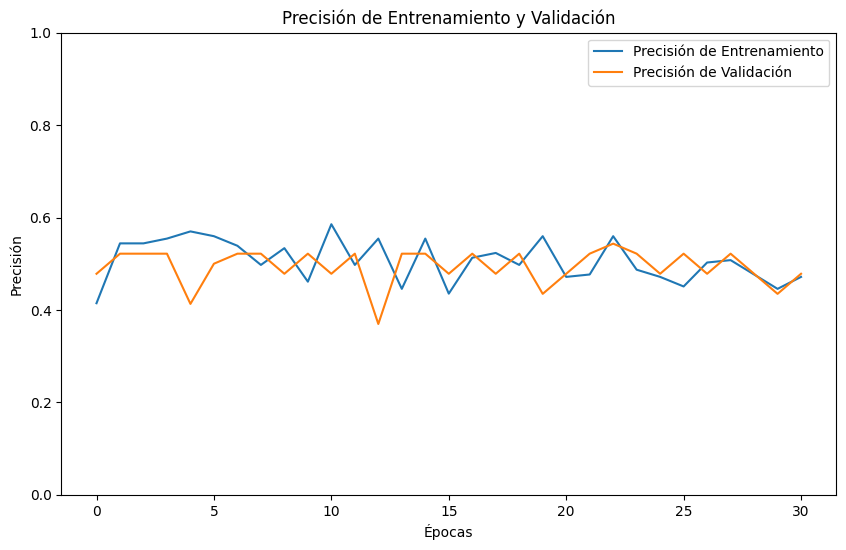

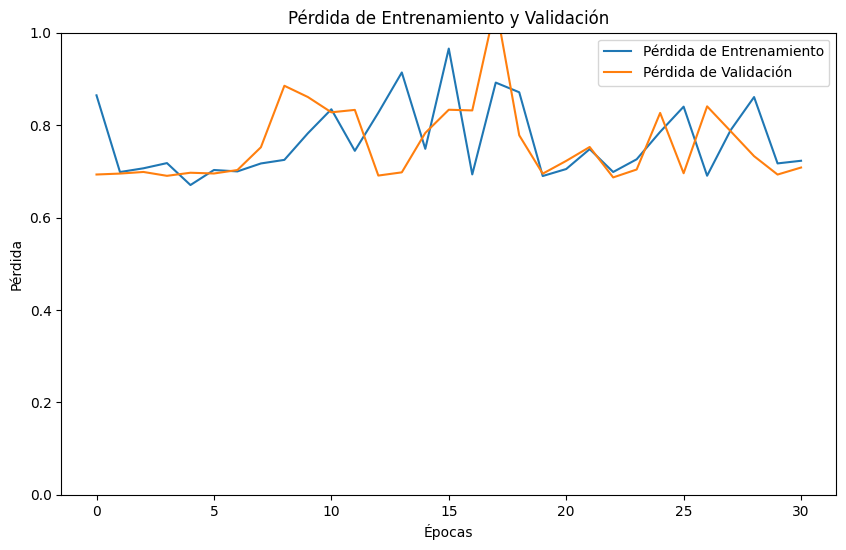

In [21]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Función para cargar las imágenes y las etiquetas desde las carpetas
def load_images(base_dir, input_size=(224, 224)):
    """
    Carga imágenes y etiquetas desde el directorio base.

    Args:
    base_dir (str): Directorio base donde están ubicadas las carpetas de imágenes.
    input_size (tuple): Tamaño al cual se redimensionarán las imágenes.

    Returns:
    data (np.array): Imágenes cargadas.
    labels (np.array): Etiquetas correspondientes.
    groups (np.array): Identificadores de los pacientes.
    """
    categories = ['high', 'low']
    data = []
    labels = []
    groups = []

    for category in categories:
        path = os.path.join(base_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = cv2.resize(image, input_size)
                image = np.stack((image,) * 3, axis=-1)
                data.append(image)
                labels.append(class_num)
                patient_id = img.split('_')[0]
                groups.append(patient_id)

    return np.array(data), np.array(labels), np.array(groups)

# Configurar generadores de imágenes
def setup_image_generators(X_train, X_val, y_train, y_val):
    """
    Configura generadores de imágenes para entrenamiento y validación.

    Args:
    X_train (np.array): Imágenes de entrenamiento.
    X_val (np.array): Imágenes de validación.
    y_train (np.array): Etiquetas de entrenamiento.
    y_val (np.array): Etiquetas de validación.

    Returns:
    train_generator, val_generator: Generadores para el entrenamiento y validación.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=5,
        zoom_range=[0.2, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow(X_train, y_train)
    val_generator = validation_datagen.flow(X_val, y_val)

    return train_generator, val_generator

# Crear el modelo
def create_model(input_shape=(224, 224, 3)):
    """
    Crea un modelo de red neuronal secuencial utilizando MobileNetV3 como base.

    Args:
    input_shape (tuple): Dimensiones de las imágenes de entrada.

    Returns:
    model: Modelo compilado de TensorFlow.
    """
    base_model = ResNet101(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ruta al directorio de imágenes
base_directory = 'db_unal/organized/images/cropped'
X, y, groups = load_images(base_directory)

# Dividir los datos en conjuntos de entrenamiento y validación
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups=groups))

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

# Configurar generadores de imágenes
train_gen, val_gen = setup_image_generators(X_train, X_val, y_train, y_val)

# Crear y compilar el modelo
model = create_model()

# Calcular los pesos de clase para manejar datos desbalanceados
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weights[i] for i in range(len(weights))}

# Configurar los callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=30,
    verbose=1,
    mode='min'
)


# Entrenar el modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy = model.evaluate(val_gen)
print(f'Validation accuracy: {val_accuracy:.4f}')

# Métricas de desempeño
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Precisión de Entrenamiento')
plt.plot(epochs, val_acc, label='Precisión de Validación')
plt.ylim(0, 1.0)
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Pérdida de Entrenamiento')
plt.plot(epochs, val_loss, label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylim(0, 1.0)
plt.ylabel('Pérdida')
plt.legend()
plt.show()

#### **SGD Optimizer**

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step
Epoch 1/50


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5460 - loss: 0.8476
Epoch 1: val_loss improved from inf to 0.94345, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.5457 - loss: 0.8511 - val_accuracy: 0.5217 - val_loss: 0.9435
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5896 - loss: 0.5731
Epoch 2: val_loss improved from 0.94345 to 0.74685, saving model to best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.5813 - loss: 0.5882 - val_accuracy: 0.4783 - val_loss: 0.7468
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4468 - loss: 1.1267
Epoch 3: val_loss did not improve from 0.74685
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.4467 - loss: 1.1352 - val_accuracy: 0.5217 - val_loss: 0.9711
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5512 - loss: 1.0062
Epoch 4: val_loss did not improve from 0.74685
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.5490 - loss: 1.0151 - val_accuracy: 0

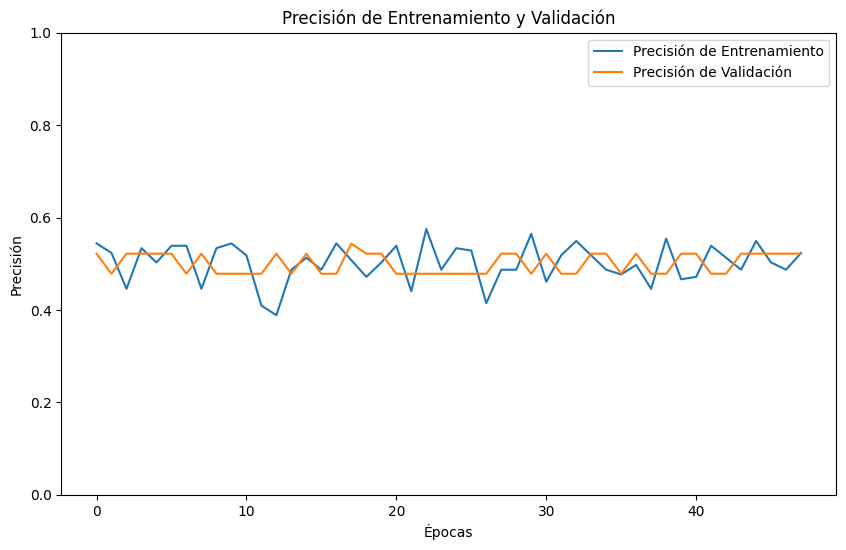

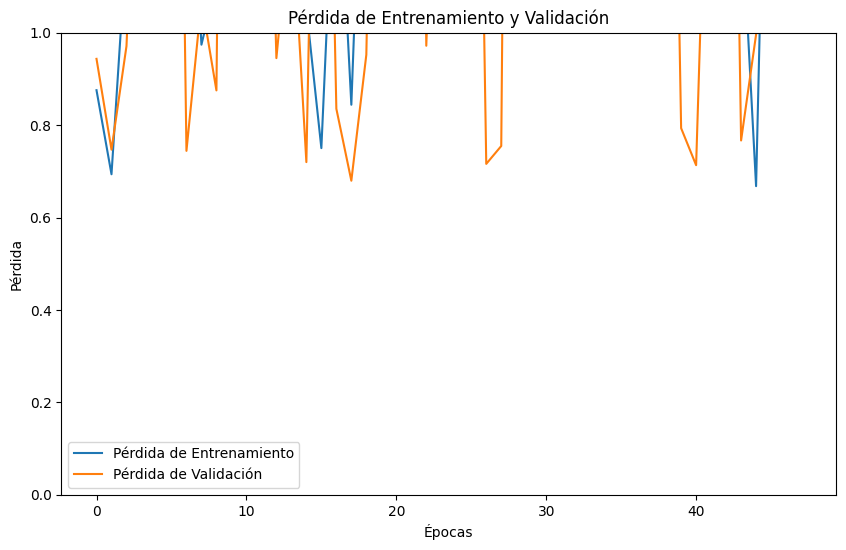

In [20]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

# Función para cargar las imágenes y las etiquetas desde las carpetas
def load_images(base_dir, input_size=(224, 224)):
    """
    Carga imágenes y etiquetas desde el directorio base.

    Args:
    base_dir (str): Directorio base donde están ubicadas las carpetas de imágenes.
    input_size (tuple): Tamaño al cual se redimensionarán las imágenes.

    Returns:
    data (np.array): Imágenes cargadas.
    labels (np.array): Etiquetas correspondientes.
    groups (np.array): Identificadores de los pacientes.
    """
    categories = ['high', 'low']
    data = []
    labels = []
    groups = []

    for category in categories:
        path = os.path.join(base_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = cv2.resize(image, input_size)
                image = np.stack((image,) * 3, axis=-1)
                data.append(image)
                labels.append(class_num)
                patient_id = img.split('_')[0]
                groups.append(patient_id)

    return np.array(data), np.array(labels), np.array(groups)

# Configurar generadores de imágenes
def setup_image_generators(X_train, X_val, y_train, y_val):
    """
    Configura generadores de imágenes para entrenamiento y validación.

    Args:
    X_train (np.array): Imágenes de entrenamiento.
    X_val (np.array): Imágenes de validación.
    y_train (np.array): Etiquetas de entrenamiento.
    y_val (np.array): Etiquetas de validación.

    Returns:
    train_generator, val_generator: Generadores para el entrenamiento y validación.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=5,
        zoom_range=[0.2, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow(X_train, y_train)
    val_generator = validation_datagen.flow(X_val, y_val)

    return train_generator, val_generator

# Crear el modelo
def create_model(input_shape=(224, 224, 3)):
    """
    Crea un modelo de red neuronal secuencial utilizando MobileNetV3 como base.

    Args:
    input_shape (tuple): Dimensiones de las imágenes de entrada.

    Returns:
    model: Modelo compilado de TensorFlow.
    """
    base_model = ResNet101(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ruta al directorio de imágenes
base_directory = 'db_unal/organized/images/cropped'
X, y, groups = load_images(base_directory)

# Dividir los datos en conjuntos de entrenamiento y validación
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups=groups))

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

# Configurar generadores de imágenes
train_gen, val_gen = setup_image_generators(X_train, X_val, y_train, y_val)

# Crear y compilar el modelo
model = create_model()

# Calcular los pesos de clase para manejar datos desbalanceados
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weights[i] for i in range(len(weights))}

# Configurar los callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=30,
    verbose=1,
    mode='min'
)

# Entrenar el modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy = model.evaluate(val_gen)
print(f'Validation accuracy: {val_accuracy:.4f}')

# Métricas de desempeño
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Precisión de Entrenamiento')
plt.plot(epochs, val_acc, label='Precisión de Validación')
plt.ylim(0, 1.0)
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Pérdida de Entrenamiento')
plt.plot(epochs, val_loss, label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylim(0, 1.0)
plt.ylabel('Pérdida')
plt.legend()
plt.show()

## **VGG**

### **VGG16**

#### **Adam Optimizer**

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Función para cargar las imágenes y las etiquetas desde las carpetas
def load_images(base_dir, input_size=(224, 224)):
    """
    Carga imágenes y etiquetas desde el directorio base.

    Args:
    base_dir (str): Directorio base donde están ubicadas las carpetas de imágenes.
    input_size (tuple): Tamaño al cual se redimensionarán las imágenes.

    Returns:
    data (np.array): Imágenes cargadas.
    labels (np.array): Etiquetas correspondientes.
    groups (np.array): Identificadores de los pacientes.
    """
    categories = ['high', 'low']
    data = []
    labels = []
    groups = []

    for category in categories:
        path = os.path.join(base_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = cv2.resize(image, input_size)
                image = np.stack((image,) * 3, axis=-1)
                data.append(image)
                labels.append(class_num)
                patient_id = img.split('_')[0]
                groups.append(patient_id)

    return np.array(data), np.array(labels), np.array(groups)

# Configurar generadores de imágenes
def setup_image_generators(X_train, X_val, y_train, y_val):
    """
    Configura generadores de imágenes para entrenamiento y validación.

    Args:
    X_train (np.array): Imágenes de entrenamiento.
    X_val (np.array): Imágenes de validación.
    y_train (np.array): Etiquetas de entrenamiento.
    y_val (np.array): Etiquetas de validación.

    Returns:
    train_generator, val_generator: Generadores para el entrenamiento y validación.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=5,
        zoom_range=[0.2, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow(X_train, y_train)
    val_generator = validation_datagen.flow(X_val, y_val)

    return train_generator, val_generator

# Crear el modelo
def create_model(input_shape=(224, 224, 3)):
    """
    Crea un modelo de red neuronal secuencial utilizando MobileNetV3 como base.

    Args:
    input_shape (tuple): Dimensiones de las imágenes de entrada.

    Returns:
    model: Modelo compilado de TensorFlow.
    """
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ruta al directorio de imágenes
base_directory = 'db_unal/organized/images/cropped'
X, y, groups = load_images(base_directory)

# Dividir los datos en conjuntos de entrenamiento y validación
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups=groups))

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

# Configurar generadores de imágenes
train_gen, val_gen = setup_image_generators(X_train, X_val, y_train, y_val)

# Crear y compilar el modelo
model = create_model()

# Calcular los pesos de clase para manejar datos desbalanceados
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weights[i] for i in range(len(weights))}

# Configurar los callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=30,
    verbose=1,
    mode='min'
)


# Entrenar el modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy = model.evaluate(val_gen)
print(f'Validation accuracy: {val_accuracy:.4f}')

# Métricas de desempeño
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Precisión de Entrenamiento')
plt.plot(epochs, val_acc, label='Precisión de Validación')
plt.ylim(0, 1.0)
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Pérdida de Entrenamiento')
plt.plot(epochs, val_loss, label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylim(0, 1.0)
plt.ylabel('Pérdida')
plt.legend()
plt.show()

#### **SGD Optimizer**

In [17]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

# Función para cargar las imágenes y las etiquetas desde las carpetas
def load_images(base_dir, input_size=(224, 224)):
    """
    Carga imágenes y etiquetas desde el directorio base.

    Args:
    base_dir (str): Directorio base donde están ubicadas las carpetas de imágenes.
    input_size (tuple): Tamaño al cual se redimensionarán las imágenes.

    Returns:
    data (np.array): Imágenes cargadas.
    labels (np.array): Etiquetas correspondientes.
    groups (np.array): Identificadores de los pacientes.
    """
    categories = ['high', 'low']
    data = []
    labels = []
    groups = []

    for category in categories:
        path = os.path.join(base_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = cv2.resize(image, input_size)
                image = np.stack((image,) * 3, axis=-1)
                data.append(image)
                labels.append(class_num)
                patient_id = img.split('_')[0]
                groups.append(patient_id)

    return np.array(data), np.array(labels), np.array(groups)

# Configurar generadores de imágenes
def setup_image_generators(X_train, X_val, y_train, y_val):
    """
    Configura generadores de imágenes para entrenamiento y validación.

    Args:
    X_train (np.array): Imágenes de entrenamiento.
    X_val (np.array): Imágenes de validación.
    y_train (np.array): Etiquetas de entrenamiento.
    y_val (np.array): Etiquetas de validación.

    Returns:
    train_generator, val_generator: Generadores para el entrenamiento y validación.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=5,
        zoom_range=[0.2, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow(X_train, y_train)
    val_generator = validation_datagen.flow(X_val, y_val)

    return train_generator, val_generator

# Crear el modelo
def create_model(input_shape=(224, 224, 3)):
    """
    Crea un modelo de red neuronal secuencial utilizando MobileNetV3 como base.

    Args:
    input_shape (tuple): Dimensiones de las imágenes de entrada.

    Returns:
    model: Modelo compilado de TensorFlow.
    """
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ruta al directorio de imágenes
base_directory = 'db_unal/organized/images/cropped'
X, y, groups = load_images(base_directory)

# Dividir los datos en conjuntos de entrenamiento y validación
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups=groups))

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

# Configurar generadores de imágenes
train_gen, val_gen = setup_image_generators(X_train, X_val, y_train, y_val)

# Crear y compilar el modelo
model = create_model()

# Calcular los pesos de clase para manejar datos desbalanceados
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weights[i] for i in range(len(weights))}

# Configurar los callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=30,
    verbose=1,
    mode='min'
)


# Entrenar el modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy = model.evaluate(val_gen)
print(f'Validation accuracy: {val_accuracy:.4f}')

# Métricas de desempeño
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Precisión de Entrenamiento')
plt.plot(epochs, val_acc, label='Precisión de Validación')
plt.ylim(0, 1.0)
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Pérdida de Entrenamiento')
plt.plot(epochs, val_loss, label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylim(0, 1.0)
plt.ylabel('Pérdida')
plt.legend()
plt.show()


Found 192 images belonging to 2 classes.
Found 47 images belonging to 2 classes.
Epoch 1/200


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.4644 - loss: 0.7041 - val_accuracy: 0.4468 - val_loss: 0.6978
Epoch 2/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.4873 - loss: 0.6979 - val_accuracy: 0.4468 - val_loss: 0.7028
Epoch 3/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.4830 - loss: 0.6909 - val_accuracy: 0.4468 - val_loss: 0.7064
Epoch 4/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.5247 - loss: 0.6954 - val_accuracy: 0.4468 - val_loss: 0.7004
Epoch 5/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.4742 - loss: 0.7006 - val_accuracy: 0.4468 - val_loss: 0.6998
Epoch 6/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.4204 - loss: 0.6975 - val_accuracy: 0.4468 - val_loss: 0.6995
Epoch 7/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.5159 - loss: 0.6899 - val_accuracy: 0.4468 - val_loss: 0.6984
Epoch 8/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.4667 - loss: 0.6951 - val_accuracy: 0.4468 - val_loss: 0.6

KeyboardInterrupt: 

### **VGG19**

#### Adam Optimizer

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Función para cargar las imágenes y las etiquetas desde las carpetas
def load_images(base_dir, input_size=(224, 224)):
    """
    Carga imágenes y etiquetas desde el directorio base.

    Args:
    base_dir (str): Directorio base donde están ubicadas las carpetas de imágenes.
    input_size (tuple): Tamaño al cual se redimensionarán las imágenes.

    Returns:
    data (np.array): Imágenes cargadas.
    labels (np.array): Etiquetas correspondientes.
    groups (np.array): Identificadores de los pacientes.
    """
    categories = ['high', 'low']
    data = []
    labels = []
    groups = []

    for category in categories:
        path = os.path.join(base_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = cv2.resize(image, input_size)
                image = np.stack((image,) * 3, axis=-1)
                data.append(image)
                labels.append(class_num)
                patient_id = img.split('_')[0]
                groups.append(patient_id)

    return np.array(data), np.array(labels), np.array(groups)

# Configurar generadores de imágenes
def setup_image_generators(X_train, X_val, y_train, y_val):
    """
    Configura generadores de imágenes para entrenamiento y validación.

    Args:
    X_train (np.array): Imágenes de entrenamiento.
    X_val (np.array): Imágenes de validación.
    y_train (np.array): Etiquetas de entrenamiento.
    y_val (np.array): Etiquetas de validación.

    Returns:
    train_generator, val_generator: Generadores para el entrenamiento y validación.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=5,
        zoom_range=[0.2, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow(X_train, y_train)
    val_generator = validation_datagen.flow(X_val, y_val)

    return train_generator, val_generator

# Crear el modelo
def create_model(input_shape=(224, 224, 3)):
    """
    Crea un modelo de red neuronal secuencial utilizando MobileNetV3 como base.

    Args:
    input_shape (tuple): Dimensiones de las imágenes de entrada.

    Returns:
    model: Modelo compilado de TensorFlow.
    """
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ruta al directorio de imágenes
base_directory = 'db_unal/organized/images/cropped'
X, y, groups = load_images(base_directory)

# Dividir los datos en conjuntos de entrenamiento y validación
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups=groups))

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

# Configurar generadores de imágenes
train_gen, val_gen = setup_image_generators(X_train, X_val, y_train, y_val)

# Crear y compilar el modelo
model = create_model()

# Calcular los pesos de clase para manejar datos desbalanceados
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weights[i] for i in range(len(weights))}

# Configurar los callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=30,
    verbose=1,
    mode='min'
)


# Entrenar el modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy = model.evaluate(val_gen)
print(f'Validation accuracy: {val_accuracy:.4f}')

# Métricas de desempeño
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Precisión de Entrenamiento')
plt.plot(epochs, val_acc, label='Precisión de Validación')
plt.ylim(0, 1.0)
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Pérdida de Entrenamiento')
plt.plot(epochs, val_loss, label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylim(0, 1.0)
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Epoch 1/50


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.5496 - loss: 0.7021 - val_accuracy: 0.4783 - val_loss: 0.8278
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.4308 - loss: 0.7853 - val_accuracy: 0.5217 - val_loss: 0.6816
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 65s 9s/step - accuracy: 0.5125 - loss: 0.6874 - val_accuracy: 0.4783 - val_loss: 0.6896
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 81s 11s/step - accuracy: 0.4725 - loss: 0.7201 - val_accuracy: 0.4783 - val_loss: 0.7638
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step - accuracy: 0.4402 - loss: 0.7579 - val_accuracy: 0.5870 - val_loss: 0.6774
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.5149 - loss: 0.7487 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 68s 9s/step - accuracy: 0.5844 - loss: 0.6450 - val_accuracy: 0.4783 - val_loss: 0.7323
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 79s 12s/step - accuracy: 0.3205 - loss: 0.7579 - val_accuracy: 0.6304 - val_loss: 0.6760
Epoch 9/50
7/7 ━━

KeyboardInterrupt: 

#### **SDG Optimizer**

Found 192 images belonging to 2 classes.
Found 47 images belonging to 2 classes.
Epoch 1/100


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 39s 975ms/step - accuracy: 0.5390 - loss: 0.7880 - val_accuracy: 0.5532 - val_loss: 0.6825
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 955ms/step - accuracy: 0.5039 - loss: 0.7320 - val_accuracy: 0.6809 - val_loss: 0.6837
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 968ms/step - accuracy: 0.4794 - loss: 0.7118 - val_accuracy: 0.5957 - val_loss: 0.6780
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 950ms/step - accuracy: 0.5277 - loss: 0.7159 - val_accuracy: 0.6596 - val_loss: 0.6828
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 961ms/step - accuracy: 0.5166 - loss: 0.6935 - val_accuracy: 0.4468 - val_loss: 0.7079
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 969ms/step - accuracy: 0.4618 - loss: 0.6987 - val_accuracy: 0.4468 - val_loss: 0.6954
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 960ms/step - accuracy: 0.4135 - loss: 0.6910 - val_accuracy: 0.4468 - val_loss: 0.6937
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 38s 951ms/step - accuracy: 0.5212 - loss: 0.6995 - val_accuracy

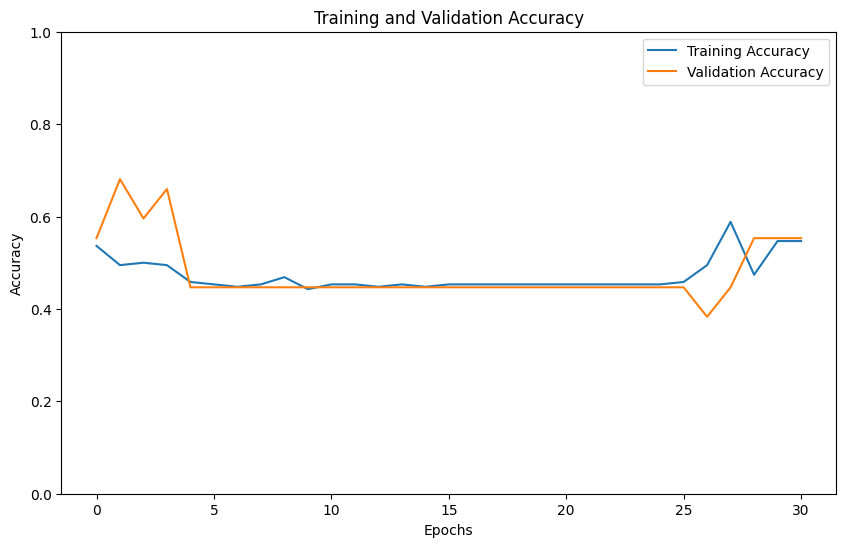

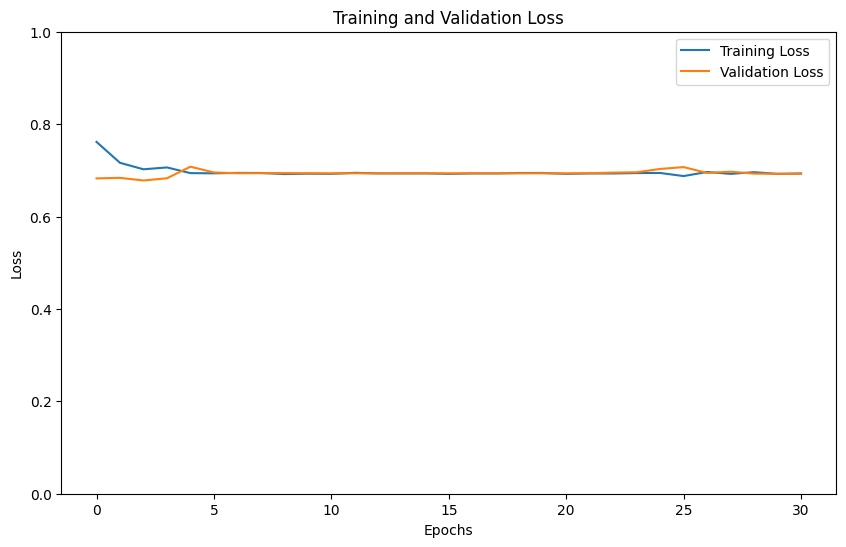

In [ ]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

# Función para cargar las imágenes y las etiquetas desde las carpetas
def load_images(base_dir, input_size=(224, 224)):
    """
    Carga imágenes y etiquetas desde el directorio base.

    Args:
    base_dir (str): Directorio base donde están ubicadas las carpetas de imágenes.
    input_size (tuple): Tamaño al cual se redimensionarán las imágenes.

    Returns:
    data (np.array): Imágenes cargadas.
    labels (np.array): Etiquetas correspondientes.
    groups (np.array): Identificadores de los pacientes.
    """
    categories = ['high', 'low']
    data = []
    labels = []
    groups = []

    for category in categories:
        path = os.path.join(base_dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = cv2.imread(img_path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                image = cv2.resize(image, input_size)
                image = np.stack((image,) * 3, axis=-1)
                data.append(image)
                labels.append(class_num)
                patient_id = img.split('_')[0]
                groups.append(patient_id)

    return np.array(data), np.array(labels), np.array(groups)

# Configurar generadores de imágenes
def setup_image_generators(X_train, X_val, y_train, y_val):
    """
    Configura generadores de imágenes para entrenamiento y validación.

    Args:
    X_train (np.array): Imágenes de entrenamiento.
    X_val (np.array): Imágenes de validación.
    y_train (np.array): Etiquetas de entrenamiento.
    y_val (np.array): Etiquetas de validación.

    Returns:
    train_generator, val_generator: Generadores para el entrenamiento y validación.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=5,
        zoom_range=[0.2, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow(X_train, y_train)
    val_generator = validation_datagen.flow(X_val, y_val)

    return train_generator, val_generator

# Crear el modelo
def create_model(input_shape=(224, 224, 3)):
    """
    Crea un modelo de red neuronal secuencial utilizando MobileNetV3 como base.

    Args:
    input_shape (tuple): Dimensiones de las imágenes de entrada.

    Returns:
    model: Modelo compilado de TensorFlow.
    """
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ruta al directorio de imágenes
base_directory = 'db_unal/organized/images/cropped'
X, y, groups = load_images(base_directory)

# Dividir los datos en conjuntos de entrenamiento y validación
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups=groups))

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

# Configurar generadores de imágenes
train_gen, val_gen = setup_image_generators(X_train, X_val, y_train, y_val)

# Crear y compilar el modelo
model = create_model()

# Calcular los pesos de clase para manejar datos desbalanceados
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weights[i] for i in range(len(weights))}

# Configurar los callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=30,
    verbose=1,
    mode='min'
)

# Entrenar el modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# Evaluar el modelo en el conjunto de validación
val_loss, val_accuracy = model.evaluate(val_gen)
print(f'Validation accuracy: {val_accuracy:.4f}')

# Métricas de desempeño
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, label='Precisión de Entrenamiento')
plt.plot(epochs, val_acc, label='Precisión de Validación')
plt.ylim(0, 1.0)
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Pérdida de Entrenamiento')
plt.plot(epochs, val_loss, label='Pérdida de Validación')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylim(0, 1.0)
plt.ylabel('Pérdida')
plt.legend()
plt.show()

## **Xception**

Found 192 images belonging to 2 classes.


Found 47 images belonging to 2 classes.
Epoch 1/100


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 423ms/step - accuracy: 0.5048 - loss: 0.6959 - val_accuracy: 0.4681 - val_loss: 0.6996
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 371ms/step - accuracy: 0.5728 - loss: 0.6876 - val_accuracy: 0.4894 - val_loss: 0.7026
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 373ms/step - accuracy: 0.4693 - loss: 0.7101 - val_accuracy: 0.4043 - val_loss: 0.7089
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 397ms/step - accuracy: 0.4532 - loss: 0.7048 - val_accuracy: 0.4681 - val_loss: 0.7043
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 25s 611ms/step - accuracy: 0.5697 - loss: 0.6754 - val_accuracy: 0.4681 - val_loss: 0.6980
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 413ms/step - accuracy: 0.4270 - loss: 0.7147 - val_accuracy: 0.4468 - val_loss: 0.7016
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 399ms/step - accuracy: 0.4617 - loss: 0.7198 - val_accuracy: 0.4468 - val_loss: 0.6959
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 404ms/step - accuracy: 0.5505 - loss: 0.6860 - val_accuracy

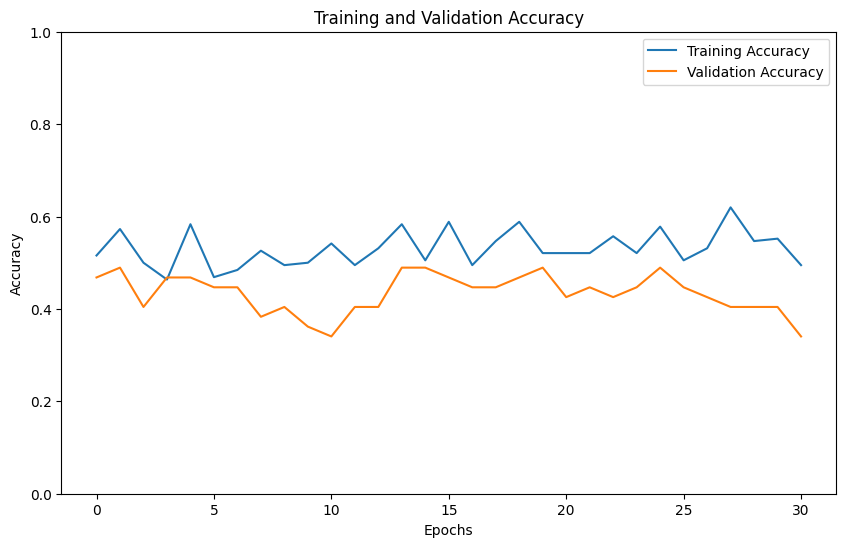

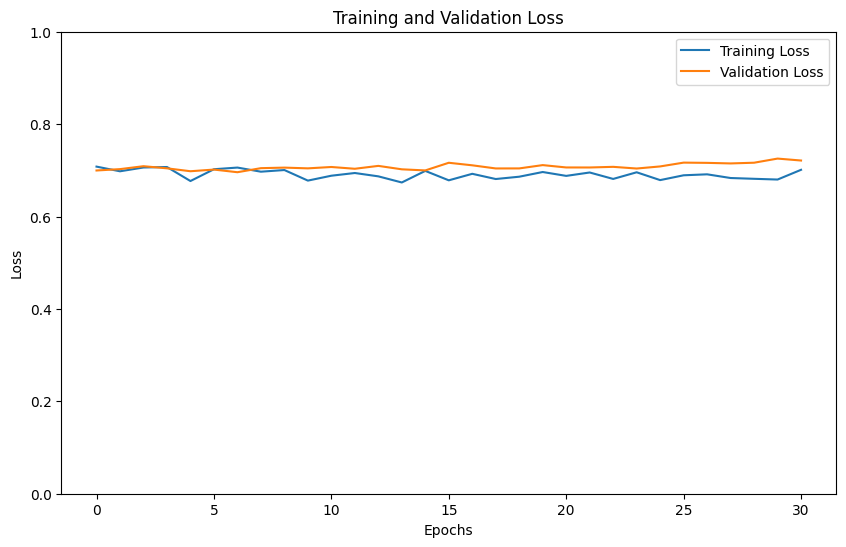

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Configurar generadores de imágenes con y sin aumento de datos
def setup_image_generators(base_dir, input_size=(224, 224), batch_size=5):
    """
    Configura generadores de imágenes para entrenamiento y validación.
    
    Args:
    base_dir (str): Directorio base donde están ubicadas las carpetas de imágenes.
    input_size (tuple): Tamaño al cual se redimensionarán las imágenes.
    batch_size (int): Número de imágenes por lote.

    Returns:
    train_generator, validation_generator: Generadores para el entrenamiento y validación.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=5,
        zoom_range=[0.2, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant',
        validation_split=0.2  # Reserva el 20% de los datos para validación
    )

    validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=input_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='training'  # Especifica que este generador es para entrenamiento
    )

    validation_generator = validation_datagen.flow_from_directory(
        base_dir,
        target_size=input_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'  # Especifica que este generador es para validación
    )

    return train_generator, validation_generator

def create_model(input_shape=(224, 224, 3)):
    """
    Crea un modelo de red neuronal secuencial utilizando Xception como base.
    
    Args:
    input_shape (tuple): Dimensiones de las imágenes de entrada.

    Returns:
    model: Modelo compilado de TensorFlow.
    """
    base_model = Xception(include_top=False, weights='imagenet', input_shape=input_shape)

    # Congelar el modelo base para reutilizar las características aprendidas en ImageNet
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(10, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Cambio para clasificación binaria
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ruta al directorio de imágenes
base_directory = 'db_unal/organized/images/cropped'
train_gen, val_gen = setup_image_generators(base_directory)

# Crear y compilar el modelo
model = create_model()

# Calcular los pesos de clase para manejar datos desbalanceados
weights = compute_class_weight(
    class_weight='balanced',  # Especifica 'balanced' para ajustar automáticamente en base a la frecuencia de clases
    classes=np.unique(train_gen.classes),  # Obtener clases únicas de los datos de entrenamiento
    y=train_gen.classes)  # Etiquetas de clase reales para cada muestra de entrenamiento

# Crear un diccionario mapeando índices de clase a sus respectivos pesos calculados
class_weights = {i: weights[i] for i in range(len(weights))}

# Configurar el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorear la pérdida de validación
    min_delta=0.01,      # Cambio mínimo detectado como una mejora
    patience=30,         # Número de épocas sin mejora después de las cuales el entrenamiento será detenido
    verbose=1,           # Mostrar mensajes de progreso
    mode='min'           # 'min' porque queremos minimizar la pérdida
)

# Entrenar el modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=200,
    class_weight=class_weights,  # Ajuste de pesos para cada clase
    #callbacks=[early_stopping]
)

# Performance Metrics

import matplotlib.pyplot as plt

# Retrieve accuracy results on training and validation data sets for each training epoch.
acc = history.history['accuracy']  # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy

# Retrieve loss results on training and validation data sets for each training epoch.
loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Determine the number of epochs, based on the length of the accuracy list.
epochs = range(len(acc))

# Plot training and validation accuracy as a function of epochs.
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylim(0, 1.0)
plt.ylabel('Accuracy')  # Label the y-axis as 'Accuracy'
plt.legend()  # Add a legend to distinguish training vs. validation

# Plot training and validation loss as a function of epochs.
plt.figure(figsize=(10, 6))  # Create a new figure for loss visualization
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Loss')  # Label the y-axis as 'Loss'
plt.ylim(0, 1.0)
plt.legend()  # Add a legend to distinguish training vs. validation
plt.show()


## **DenseNet**

Found 192 images belonging to 2 classes.
Found 47 images belonging to 2 classes.
Epoch 1/100


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 29s 424ms/step - accuracy: 0.6277 - loss: 0.7942 - val_accuracy: 0.4255 - val_loss: 0.7240
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 315ms/step - accuracy: 0.5157 - loss: 0.6916 - val_accuracy: 0.5106 - val_loss: 0.7079
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 314ms/step - accuracy: 0.5220 - loss: 0.7070 - val_accuracy: 0.4894 - val_loss: 0.6936
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 306ms/step - accuracy: 0.5295 - loss: 0.6940 - val_accuracy: 0.4681 - val_loss: 0.6977
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 304ms/step - accuracy: 0.5652 - loss: 0.6919 - val_accuracy: 0.4681 - val_loss: 0.6999
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 306ms/step - accuracy: 0.4763 - loss: 0.6981 - val_accuracy: 0.5532 - val_loss: 0.6930
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 306ms/step - accuracy: 0.5498 - loss: 0.6928 - val_accuracy: 0.5532 - val_loss: 0.6929
Epoch 8/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 305ms/step - accuracy: 0.5062 - loss: 0.6985 - val_accuracy

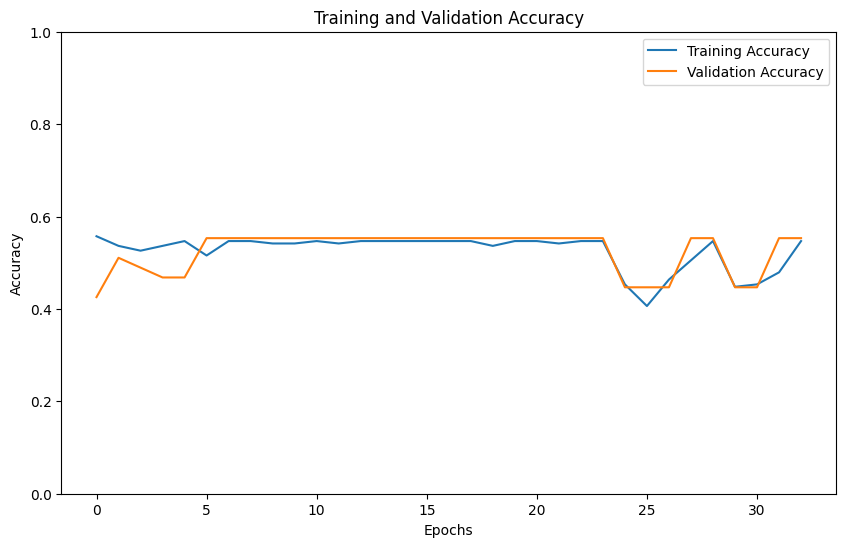

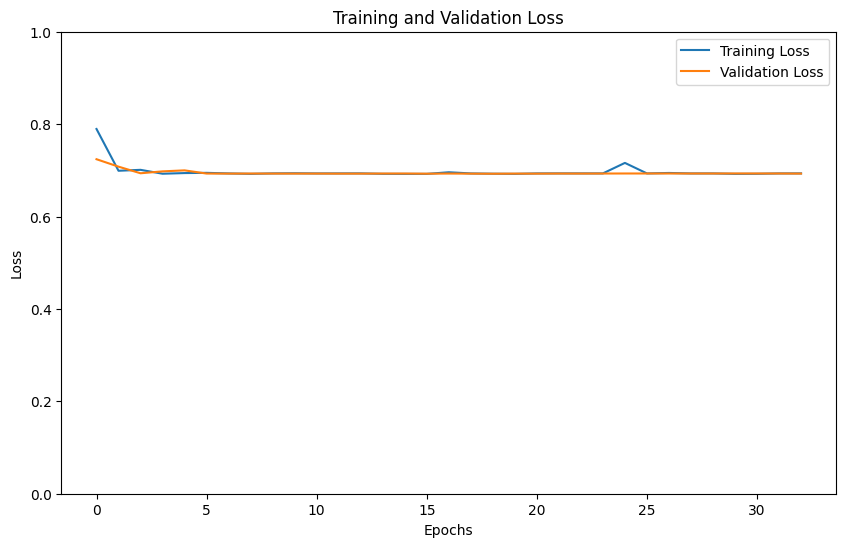

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Configurar generadores de imágenes con y sin aumento de datos
def setup_image_generators(base_dir, input_size=(224, 224), batch_size=5):
    """
    Configura generadores de imágenes para entrenamiento y validación.
    
    Args:
    base_dir (str): Directorio base donde están ubicadas las carpetas de imágenes.
    input_size (tuple): Tamaño al cual se redimensionarán las imágenes.
    batch_size (int): Número de imágenes por lote.

    Returns:
    train_generator, validation_generator: Generadores para el entrenamiento y validación.
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=5,
        zoom_range=[0.2, 1.2],
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant',
        validation_split=0.2  # Reserva el 20% de los datos para validación
    )

    validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        base_dir,
        target_size=input_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='training'  # Especifica que este generador es para entrenamiento
    )

    validation_generator = validation_datagen.flow_from_directory(
        base_dir,
        target_size=input_size,
        batch_size=batch_size,
        class_mode='binary',
        subset='validation'  # Especifica que este generador es para validación
    )

    return train_generator, validation_generator

def create_model(input_shape=(224, 224, 3)):
    """
    Crea un modelo de red neuronal secuencial utilizando DenseNet como base.
    
    Args:
    input_shape (tuple): Dimensiones de las imágenes de entrada.

    Returns:
    model: Modelo compilado de TensorFlow.
    """
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)

    # Congelar el modelo base para reutilizar las características aprendidas en ImageNet
    base_model.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Reduce la dimensionalidad de la salida del modelo base
        Dense(256, activation='relu'),  # Primera capa densa adicional con 256 neuronas
        Dropout(0.5),  # Dropout para reducir el sobreajuste
        Dense(128, activation='relu'),  # Segunda capa densa adicional con 128 neuronas
        Dropout(0.5),  # Dropout para reducir el sobreajuste
        Dense(64, activation='relu'),  # Tercera capa densa adicional con 64 neuronas
        Dropout(0.5),  # Dropout para reducir el sobreajuste
        Dense(1, activation='sigmoid')  # Capa de salida para clasificación binaria
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Ruta al directorio de imágenes
base_directory = 'db_unal/organized/images/cropped'
train_gen, val_gen = setup_image_generators(base_directory)

# Crear y compilar el modelo
model = create_model()

# Calcular los pesos de clase para manejar datos desbalanceados
weights = compute_class_weight(
    class_weight='balanced',  # Especifica 'balanced' para ajustar automáticamente en base a la frecuencia de clases
    classes=np.unique(train_gen.classes),  # Obtener clases únicas de los datos de entrenamiento
    y=train_gen.classes)  # Etiquetas de clase reales para cada muestra de entrenamiento

# Crear un diccionario mapeando índices de clase a sus respectivos pesos calculados
class_weights = {i: weights[i] for i in range(len(weights))}

# Configurar el callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorear la pérdida de validación
    min_delta=0.01,      # Cambio mínimo detectado como una mejora
    patience=30,         # Número de épocas sin mejora después de las cuales el entrenamiento será detenido
    verbose=1,           # Mostrar mensajes de progreso
    mode='min'           # 'min' porque queremos minimizar la pérdida
)

# Entrenar el modelo
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=200,
    class_weight=class_weights,  # Ajuste de pesos para cada clase
    callbacks=[early_stopping]
)

# Performance Metrics

import matplotlib.pyplot as plt

# Retrieve accuracy results on training and validation data sets for each training epoch.
acc = history.history['accuracy']  # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy

# Retrieve loss results on training and validation data sets for each training epoch.
loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Determine the number of epochs, based on the length of the accuracy list.
epochs = range(len(acc))

# Plot training and validation accuracy as a function of epochs.
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylim(0, 1.0)
plt.ylabel('Accuracy')  # Label the y-axis as 'Accuracy'
plt.legend()  # Add a legend to distinguish training vs. validation

# Plot training and validation loss as a function of epochs.
plt.figure(figsize=(10, 6))  # Create a new figure for loss visualization
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')  # Set the title of the graph
plt.xlabel('Epochs')  # Label the x-axis as 'Epochs'
plt.ylabel('Loss')  # Label the y-axis as 'Loss'
plt.ylim(0, 1.0)
plt.legend()  # Add a legend to distinguish training vs. validation
plt.show()


Epoch 1/50


c:\Users\alema\Desktop\paper\nodulos_tiroideos\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


37/39 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5759 - loss: 0.7013
Epoch 1: val_loss improved from inf to 0.68895, saving model to best_model.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.5737 - loss: 0.7029 - val_accuracy: 0.5217 - val_loss: 0.6890
Epoch 2/50
38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4580 - loss: 0.6951
Epoch 2: val_loss did not improve from 0.68895
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.4582 - loss: 0.6963 - val_accuracy: 0.5217 - val_loss: 0.6982
Epoch 3/50
38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4656 - loss: 0.7235
Epoch 3: val_loss did not improve from 0.68895
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4667 - loss: 0.7233 - val_accuracy: 0.5217 - val_loss: 0.6947
Epoch 4/50
37/39 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4113 - loss: 0.7360
Epoch 4: val_loss did not improve from 0.68895
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4135 - loss: 0.7367 - val_accuracy: 0.4783 - va

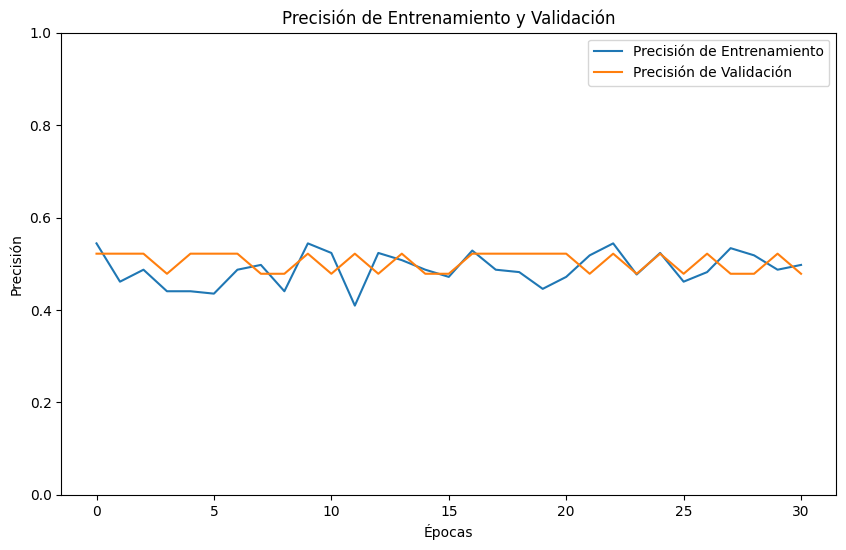

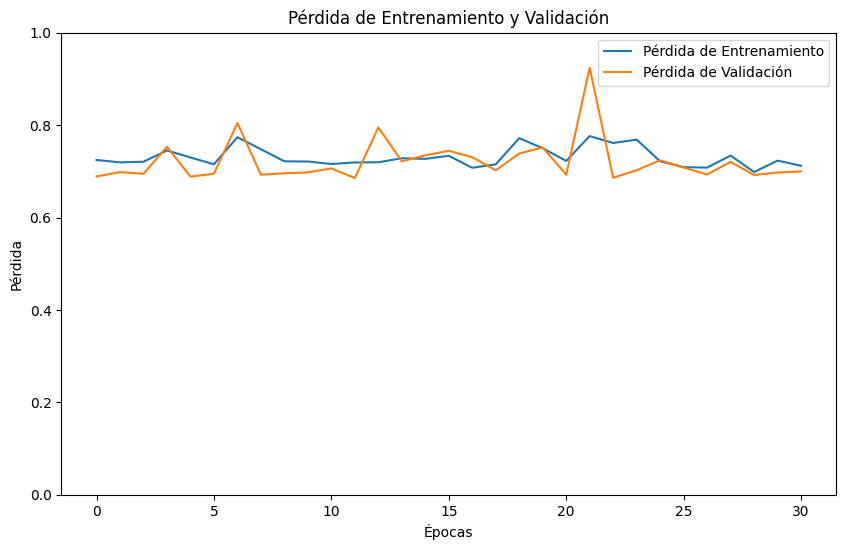